# CNN Image Data Preview & Statistics

### Welcome! 

This notebook allows you to preview your single-cell image patches to make sure your annotated data are of good quality. You will also get a chance to calculate the statistics for your annotated data which can be useful for data preprocessing, e.g. *class imbalance check* prior to CNN training.


In [92]:
try: 
    import cellx
except:
    !pip3 install -q git+git://github.com/quantumjot/cellx.git

In [93]:
import os
import json
import random
import zipfile

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from datetime import datetime
from skimage.io import imread

from cellx.tools.io import read_annotations

### Specify the import directory: 

Specify the path where your annotation zip files are stored. *Default* import directory: `../data/`

In [94]:
root = "../data/"
zipfiles = [f for f in os.listdir(root) if f.startswith("annotation") and f.endswith(".zip")]

Choose whether you'd like to save out the figures to be visualised below. There will be saved in the *default* directory: `../assets/`

In [99]:
save_statistic = True
save_collage = False

### Load the annotations = image + labels pairs: 

Read the annotated images and their respective labels & calculate the proportion of un/flagges patches per each class label. 

*Reminder:* 'flagged' image means it was cropped from the edge of the original image so that 0s padding is included in one or more patch edges.

In [96]:
images_flag, labels_flag, states= read_annotations(path=root, use_flagged=True)
images_pure, labels_pure, _ = read_annotations(path=root, use_flagged=False)

flag = [labels_flag.count(label) for label in states.values()]
pure = [labels_pure.count(label) for label in states.values()]
diff = [f - p for f, p in zip(flag, pure)]


### Specify the colors of the statistics figure:

In [97]:
COLOR_CYCLE = [
    '#1f77b4', # blue
    '#ff7f0e', # orange
    '#2ca02c', # green
    '#d62728', # red
    '#9467bd', # purple
    '#8b4513', # brown
]

### Plot the statistics:

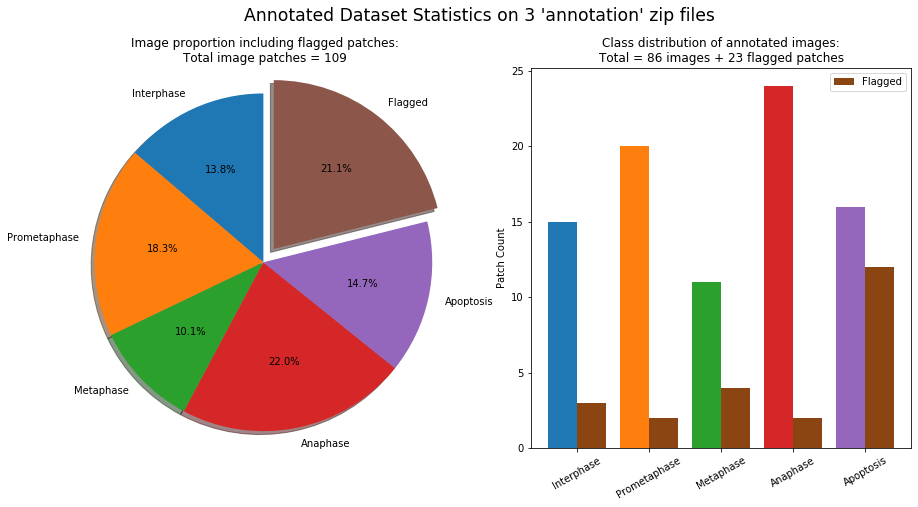

In [100]:
fig, axs = plt.subplots(figsize=(15, 7), nrows=1, ncols=2)
fig.suptitle(x=0.5, y=1.0, t=f"Annotated Dataset Statistics on {len(zipfiles)} 'annotation' zip files", fontsize="xx-large")

axs[0].pie(pure + [sum(diff)], explode=[0 for _ in range(len(pure))] + [0.1], 
           labels=list(states.keys()) + ["Flagged"], autopct='%1.1f%%', shadow=True, startangle=90)
axs[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
axs[0].set_title(f"Image proportion including flagged patches:\nTotal image patches = {len(labels_flag)}")

width = 0.4  # the width of the bars
lbls = list(states.keys())
x = np.arange(len(lbls))  # the label locations

axs[1].bar(x=x - width/2, height=pure, width=width, color=COLOR_CYCLE)
axs[1].bar(x=x + width/2, height=diff, width=width, color=COLOR_CYCLE[-1], label="Flagged")
axs[1].set_xticks(ticks=list(range(len(lbls))))
axs[1].set_xticklabels(labels=lbls, rotation=30)
axs[1].set_title(f"Class distribution of annotated images:\nTotal = {sum(pure)} images + {sum(diff)} flagged patches")
axs[1].set_ylabel(f"Patch Count")

plt.legend()

if save_statistic is True:
    plt.savefig("../assets/annotation_statistics.png", bbox_inches="tight", pad_inches=0)

plt.show()

# Visualise the annotated patches:

### Create an array grid:

In [62]:
# Create a grid of random image patches per class:

ncols, nrows = 20, 5

noise_patches = [[np.random.randint(0,255,size=(64,64)).astype(np.uint8) for i in range(nrows * ncols)] for _ in range(len(states))]
class_patches = [[p for p, l in zip(images_flag, labels_flag) if l == lab] for lab in list(states.values())]

# Replace in the noise_patches:
for i in range(len(list(states.values()))):
    noise_patches[i][0:len(class_patches[i])] = class_patches[i]


### Plot the patches on the grid:

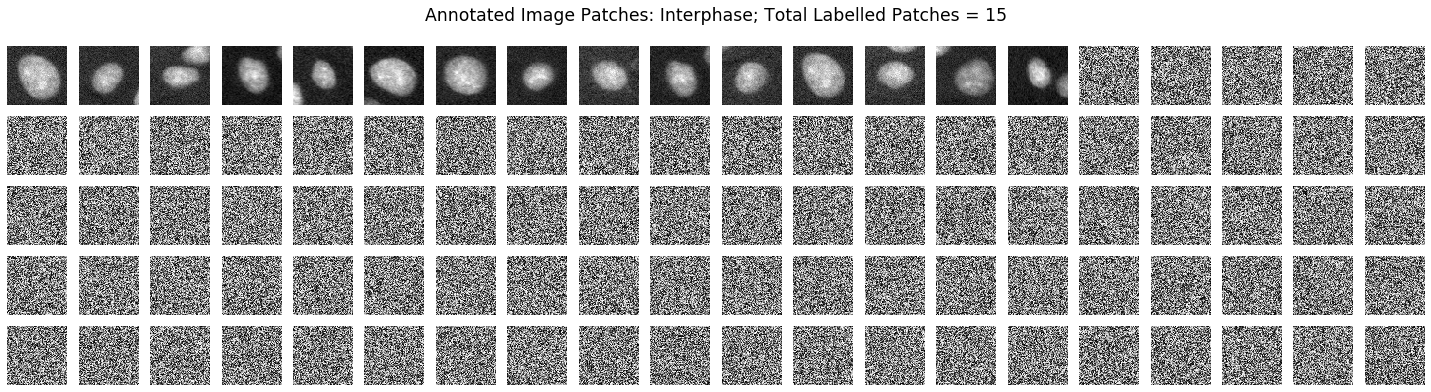

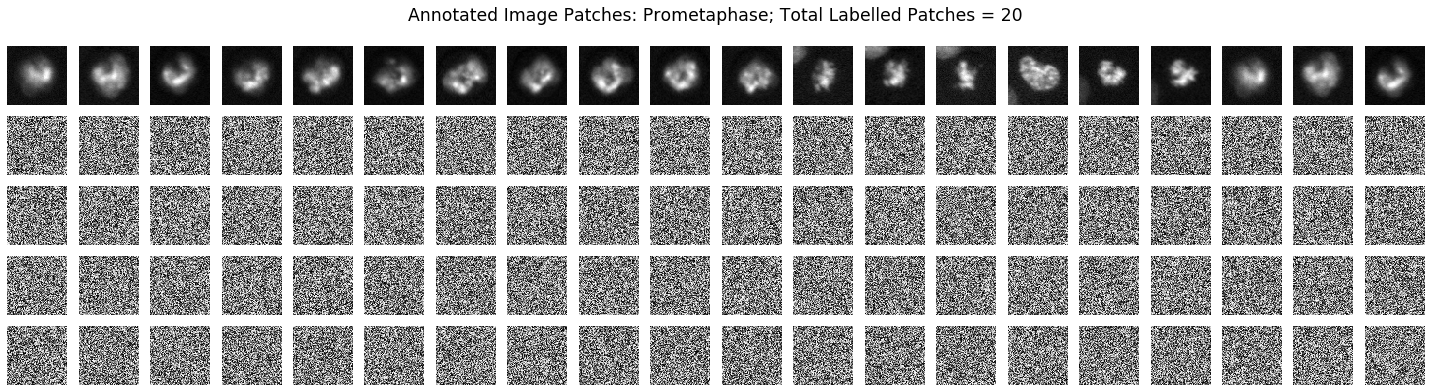

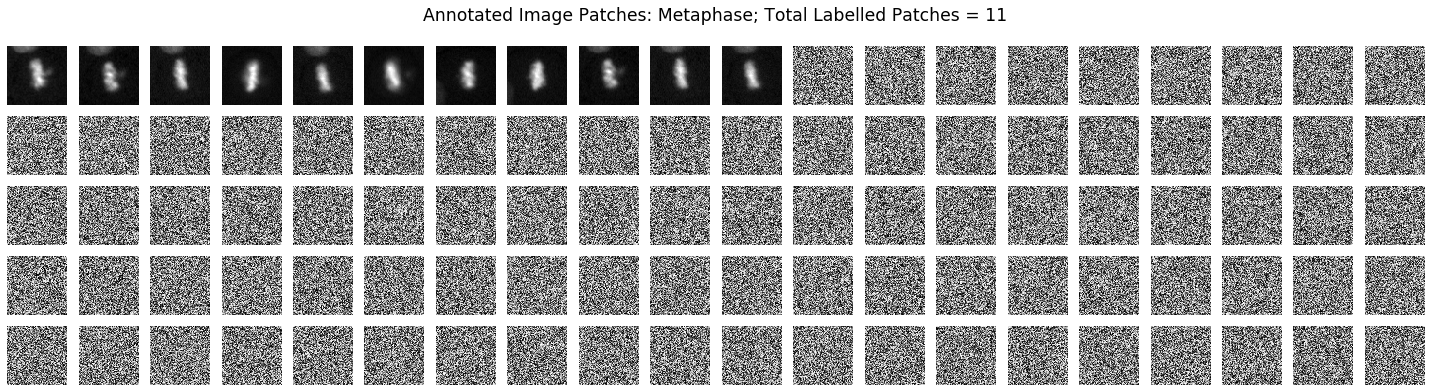

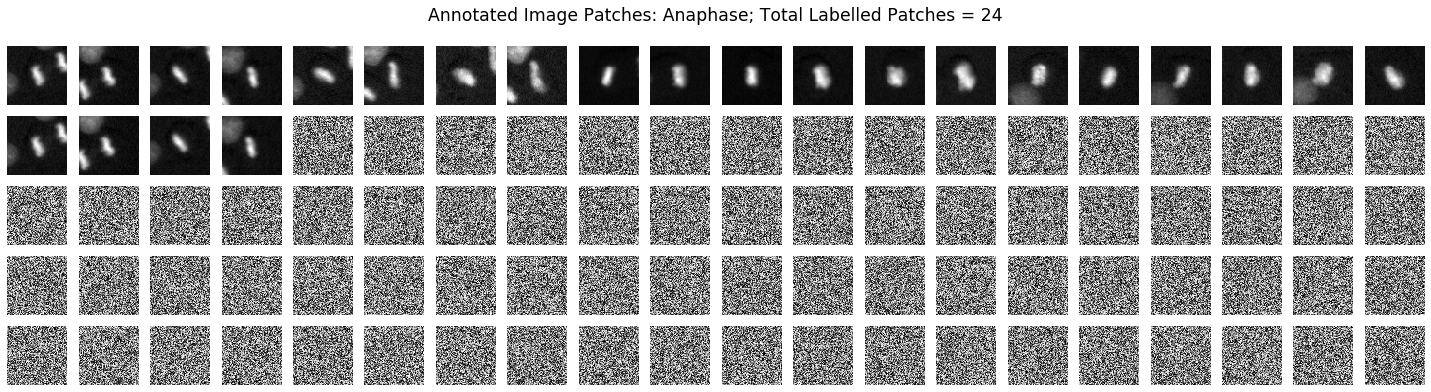

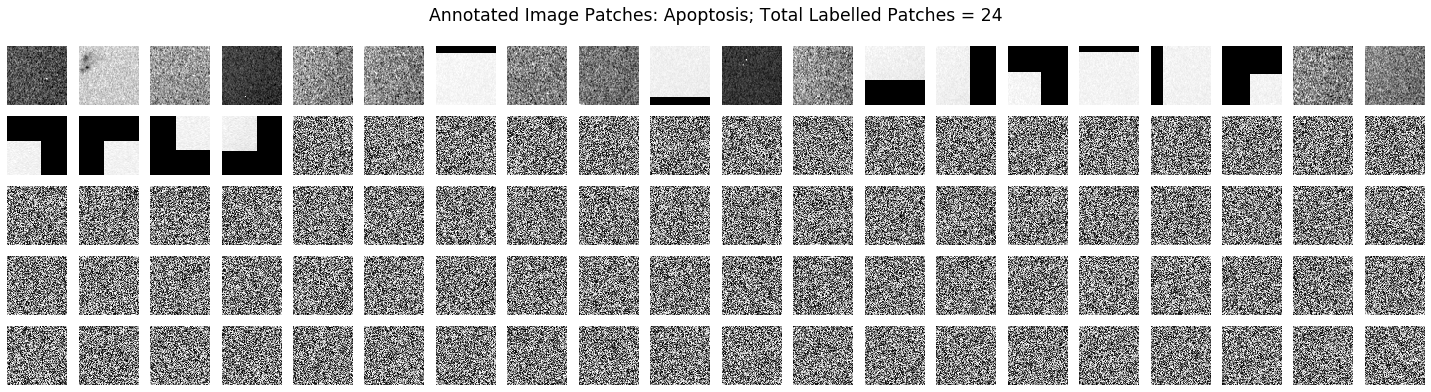

In [64]:
for i in range(len(list(states.keys()))):
    phase = list(states.keys())[i]
    
    patch_count = len(class_patches[i])
    if patch_count > 100:
        nrows = patch_count // ncols + 1
    
    fig, axs = plt.subplots(figsize=(ncols, nrows), nrows=nrows, ncols=ncols, sharex=True, sharey=True)
    fig.suptitle(x=0.5, y=1.08, t=f"Annotated Image Patches: {phase}; Total Labelled Patches = {patch_count}", fontsize="xx-large")

    for idx in range(len(noise_patches[i])):

        axs[idx // ncols][idx % ncols].imshow(noise_patches[i][idx], cmap="binary_r")
        axs[idx // ncols][idx % ncols].axis('off')

    plt.tight_layout()
    
    if save_collage is True:
        plt.savefig(f"../assets/annotation_grid_{phase}.png", bbox_inches="tight", pad_inches=0)

    plt.show()
    

### Done!